In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
!gdown https://drive.google.com/u/0/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&export=download
!tar -xzf 101_ObjectCategories.tar.gz

Downloading...
From: https://drive.google.com/u/0/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
To: /content/101_ObjectCategories.tar.gz
100% 132M/132M [00:02<00:00, 64.7MB/s]


In [3]:
import tensorflow as tf
import tensorflow.keras as k
import numpy as np
import matplotlib.pyplot as plt

In [4]:
N_samples_Caltech101 = 9144
val_split = 0.1
datagen = k.preprocessing.image.ImageDataGenerator(validation_split=val_split,
                                                   preprocessing_function=k.applications.mobilenet_v2.preprocess_input,
                                                   rotation_range=20,
                                                   width_shift_range=0.1,
                                                   height_shift_range=0.1,
                                                   shear_range=0.1,
                                                   zoom_range=0.1,
                                                   horizontal_flip=True)

In [5]:
# Instantiate a MobileNetV2 with weights pretrained on ImageNet and without the top/output layer. Hint: Use Keras Applications

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [6]:
class MyTransferModel(k.Model):
    def __init__(self, pretrained_model):
        super(MyTransferModel, self).__init__()
        # Define layers and pretrained model
        self.pretrained_model = pretrained_model
        self.avgpooling = k.layers.GlobalAveragePooling2D()
        self.dropout = k.layers.Dropout(rate=0.25)
        self.dense = k.layers.Dense(units=102, activation="softmax")

    def call(self, inputs, training=False):
        # Call pretrained model and layers appropriately to implement forward pass
        output = self.pretrained_model(inputs)
        output = self.avgpooling(output)
        output = self.dropout(output, training)
        output = self.dense(output)
        return output

In [7]:
# Instantiate a MyTransferModel object and a RMSprop optimizer, compile them with a suitable loss and accuracy as a metric. Use "base_model" as the pretrained model. """

tf_batch_size = 32
tf_epochs = 10
tf_learning_rate = 0.001
tf_mdl = MyTransferModel(base_model)
tf_opt =tf.optimizers.RMSprop(tf_learning_rate)
base_model.trainable = False
tf_mdl.compile(optimizer=tf_opt,
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])
tf_mdl.build((tf_batch_size, 224, 224, 3))
tf_mdl.summary()

train_gen = datagen.flow_from_directory(directory="101_ObjectCategories", class_mode="sparse", target_size=(224, 224), batch_size=tf_batch_size, subset="training")
val_gen = datagen.flow_from_directory(directory="101_ObjectCategories", class_mode="sparse", target_size=(224, 224), batch_size=tf_batch_size, subset="validation")
tf_history_0 = tf_mdl.fit(train_gen, validation_data=val_gen, batch_size=tf_batch_size, epochs=tf_epochs, steps_per_epoch=int((1.0-val_split)*N_samples_Caltech101/tf_batch_size), validation_steps=int(val_split*N_samples_Caltech101/tf_batch_size))

Model: "my_transfer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________
Found 8278 images belonging to 10

In [8]:
# Reinstantiate the RMSprop optimizer with the changed learning rate and set the base_model to be trainable. Then compile it with the newly instantiate optimizer, a suitable loss function and accuracy as a metric 
# and continue training on the Caltech101 data set

tf_learning_rate = 0.00001
tf_opt = tf.optimizers.RMSprop(tf_learning_rate)
base_model.trainable=True # Set base_model to be trainable
tf_mdl.compile(loss="sparse_categorical_crossentropy", optimizer=tf_opt, metrics=["accuracy"])
tf_mdl.build((tf_batch_size, 224, 224, 3))
tf_mdl.summary()

tf_history_1 = tf_mdl.fit(train_gen, validation_data=val_gen, steps_per_epoch=int((1.0-val_split)*N_samples_Caltech101/tf_batch_size), validation_steps=int(val_split*N_samples_Caltech101/tf_batch_size), epochs=tf_epochs, batch_size=tf_batch_size)

Model: "my_transfer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  130662    
                                                                 
Total params: 2,388,646
Trainable params: 2,354,534
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/10
257/257 [==============

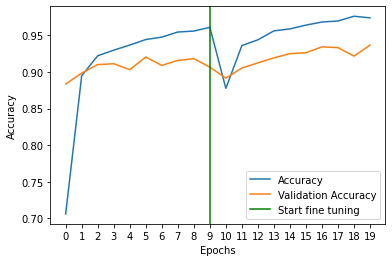

In [11]:
plt.plot(tf_history_0.history["accuracy"]+tf_history_1.history["accuracy"])
plt.plot(tf_history_0.history["val_accuracy"]+tf_history_1.history["val_accuracy"])
plt.xticks(range(len(tf_history_0.history["accuracy"]+tf_history_1.history["accuracy"])))
plt.axvline(9, color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy", "Start fine tuning"])
plt.show()